# Rumour veracity prediction through sequential domain adaptation


Quoting the website of the PHEME project: "Social networks are rife with lies and deception, half-truths and facts. But irrespective of a meme’s truthfulness, the rapid spread of such information through social networks and other online media can have immediate and far-reaching consequences. In such cases, large amounts of user-generated content need to be analysed quickly, yet it is not currently possible to carry out such complex analyses in real time."

For my 'sequential domain adaptation' project I am classification problems where the training and test samples originate from different distributions. This type of scenario occurs often. Knowledge of how classifiers may "adapt" to account for differences between underlying distributions is crucial to improving machine learning systems. The main problem in domain adaptation is that the "domains" are often very dissimilar, which means that there is a lot of uncertainty about the adaptation step.

Instead of adapting to a very dissimilar domain, the problem might be a lot easier if we would find "intermediate" domains and perform a sequence of small adaptation steps.


Rumours tend to change over time; people discuss different aspects of the story. If we were to characterize expressions using a Bag-of-Words encoding, then one could view this process as a distribution over words that evolves over time. The same is still true for other encodings, but the example is less intuitive.

But people sleep. Which means that the change in word-use-statistics is larger _between_ days than _within_ days. It is difficult to classify a continuously changing process, but given a nearly 'piecewise-constant' process, we could learn something about the rumour today, and adapt to the different situtation tomorrow. 

The PHEME-journalism data set contains tweets of rumours for subsequent days. They are hand-labeled as 'misinformation' or not. I want to explore whether I can improve day-to-day rumour veracity prediction by using domain-adaptive classifiers.

In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import numpy as np
import pandas as pd
import pickle as pc
import gzip as gz

from gensim.utils import tokenize
from gensim.models import KeyedVectors

from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from libtlda.iw import ImportanceWeightedClassifier

2018-10-22 18:56:25,888 : INFO : 'pattern' package not found; tag filters are not available for English


In [2]:
import matplotlib.pyplot as plt

# Set font size
fS = 20

In [118]:
# Load data
tweets = pd.read_csv('PHEMEj.csv', sep='\t')

In [119]:
# Select rumours
rumours = np.unique(tweets['which_rumour'].astype('str'))
print(rumours)

['charliehebdo' 'ebola-essien' 'ferguson' 'germanwings-crash'
 'ottawashooting' 'prince-toronto' 'putinmissing' 'sydneysiege']


Unfortunately, many of the rumours are discussed for less than 3 days or only contain tweets of one class. For now, I'm only using the 'charliehebdo' rumour.

In [120]:
# Visualize tweets of rumour 'charliehebdo' for each day

# Select tweets
tweets_r = tweets[tweets['which_rumour'] == 'charliehebdo']

print(tweets_r.shape)

(74, 6)


In [6]:
# Initialize Google's Word2Vec format
model = KeyedVectors.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin', binary=True)  

2018-10-22 18:56:26,671 : INFO : loading projection weights from ../data/GoogleNews-vectors-negative300.bin
2018-10-22 18:57:24,381 : INFO : loaded (3000000, 300) matrix from ../data/GoogleNews-vectors-negative300.bin


In [144]:
# Map tweet text to Word2Vec

# Preallocate text array
X = np.zeros((tweets_r.shape[0], 300))

# Iterate over tweets
for r, tweet in enumerate(tweets_r['content']):
    
    # Iterate over tokens
    vec = 0
    num = 0
    for token in tokenize(tweet):
        
        try:
            # Add embedding
            vec += model.wv[token]
            num += 1
            
        except:
            # Skip unknown word
            continue
    
    # Add to array
    X[r, :] = vec/num

# Obtain labels
Y = tweets_r['misinformation'].as_matrix()
        

/home/wmkouw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()


In [129]:
# Reduce data dimensionality
# X = PCA(n_components=2).fit_transform(X)

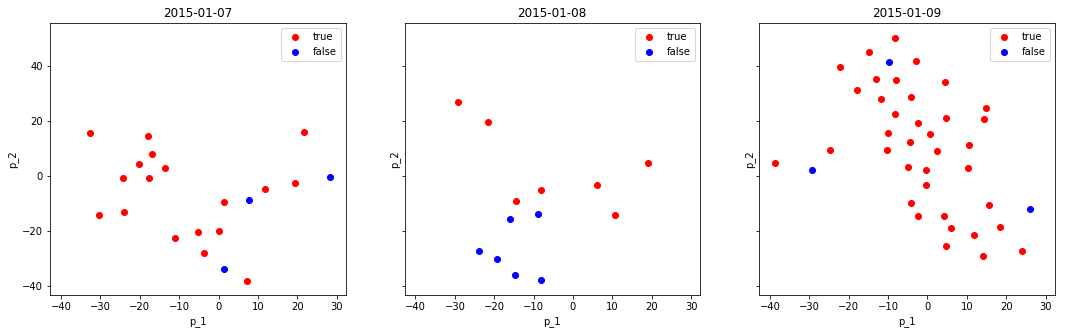

In [155]:
# Visualize tweets for each day

# List of days on which was tweeted
days = np.unique(tweets_r['created_date'])

# T-SNE on data
Z = TSNE(n_components=2).fit_transform(X)

# Initialize figure
fig, ax = plt.subplots(ncols=len(days), figsize=(18,5), sharex=True, sharey=True)

# Loop over days
for d, day in enumerate(days):
    
    # Take indices of today
    ix_d = (tweets_r['created_date'] == day).values
    
    # Split data
    X_d = Z[ix_d, :]
    Y_d = Y[ix_d]

    ax[d].scatter(X_d[Y_d == 0, 0], X_d[Y_d == 0, 1], color='r', label='true')
    ax[d].scatter(X_d[Y_d == 1, 0], X_d[Y_d == 1, 1], color='b', label='false')
    ax[d].set_title(day)
    ax[d].set_xlabel('p_1')
    ax[d].set_ylabel('p_2')
    ax[d].legend()
    
plt.show()

## Naive  classifier

I'll first try a naive classifier, for each rumour, on a day-to-day basis.

In [156]:
# Preallocate performance array
perf_array = []
days_array = []
rums_array = []

# Loop over days
for d in range(1, len(days)):

    # Set range up to yesterday
    past = range(d)

    # Create training data from all previous days
    trn_index = tweets_r['created_date'].isin(days[past]).values.tolist()

    # Find all tweets from today
    tst_index = (tweets_r['created_date'] == days[d]).values.tolist()

    # Split out training data
    trn_X = X[trn_index, :]
    trn_Y = Y[trn_index]

    # Split out test data
    tst_X = X[tst_index, :]
    tst_Y = Y[tst_index]

    # Define classifier
    clf = linear_model.LogisticRegression(C=0.1)

    # Train classifier on data from previous days
    clf.fit(trn_X, trn_Y)

    # Make predictions on test set
    preds = clf.predict(tst_X)

    # Test on data from current day and store
    perf_array.append(np.mean(preds == tst_Y))

    # Store day and rumour
    days_array.append(days[d])

# Compact to DataFrame
results = pd.DataFrame({'days': days_array,
                        'acc_naive': perf_array,})


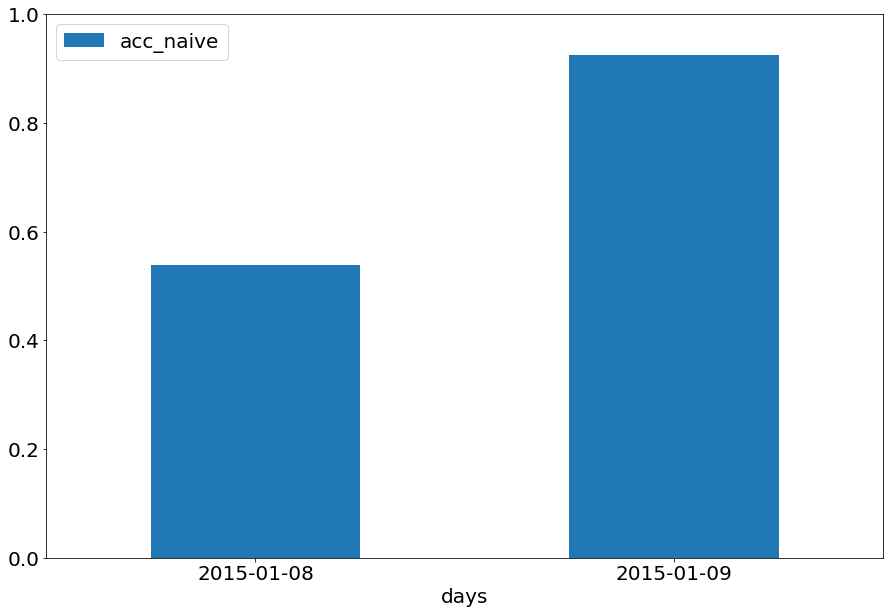

In [157]:
# Visualize performance in bar graph

# Initialize figure
fig, ax = plt.subplots(figsize=(15, 10))

# Bar plot
results.plot.bar(ax=ax, x='days', rot=0, fontsize=fS);

# Set axes properties
ax.set_ylim([0, 1]);
ax.legend(fontsize=fS, loc=2);
ax.set_xlabel('days', fontsize=fS);

## Adding a standard domain-adaptive classifier

I've built a library of domain-adaptive classifiers and transfer learners. I'm just going to use a simple adaptive classifier, to get an impression of its performance.

In [164]:
# Preallocate performance array
perf_array = []

# Preallocate importance-weight array (for further analysis)
iw = []

# Select importance-weight estimator
iwe = 'nn'

# Loop over days
for d in range(1, len(days)):

    # Set range up to yesterday
    past = range(d)
    
    # Data from yesterday
    yestd = (tweets_r['created_date'] == days[d-1]).values.tolist()
        
    # Data from all previous days
    pastd = tweets_r['created_date'].isin(days[past]).values.tolist()

    # Data from today
    today = (tweets_r['created_date'] == days[d]).values.tolist()

    # Split out training data
    trn_X = X[pastd, :]
    trn_Y = Y[pastd]

    # Split out test data
    tst_X = X[today, :]
    tst_Y = Y[today]

    # Define classifier
    clf = ImportanceWeightedClassifier(loss='logistic', iwe=iwe, l2=0.1)
    
    # Extract importance weights
    if iwe == 'nn':
        iw.append(clf.iwe_nearest_neighbours(X[yestd, :], X[today, :]))
    elif iwe == 'kmm':
        iw.append(clf.iwe_kernel_mean_matching(X[yestd, :], X[today, :]))
    elif iwe == 'kde':
        iw.append(clf.iwe_kernel_densities(X[yestd, :], X[today, :]))

    # Train classifier on labeled data from previous days and unlabeled data from today
    clf.fit(trn_X, trn_Y, tst_X)

    # Make predictions on test set
    preds = clf.predict(tst_X)

    # Test on data from current day and store
    perf_array.append(np.mean(preds == tst_Y))

# Compact to DataFrame
results['acc_adaptive'] = pd.Series(perf_array, index=results.index)

# Add unit weights
iw.append(np.ones((np.sum(tweets_r['created_date'] == days[d]), ))/2.)


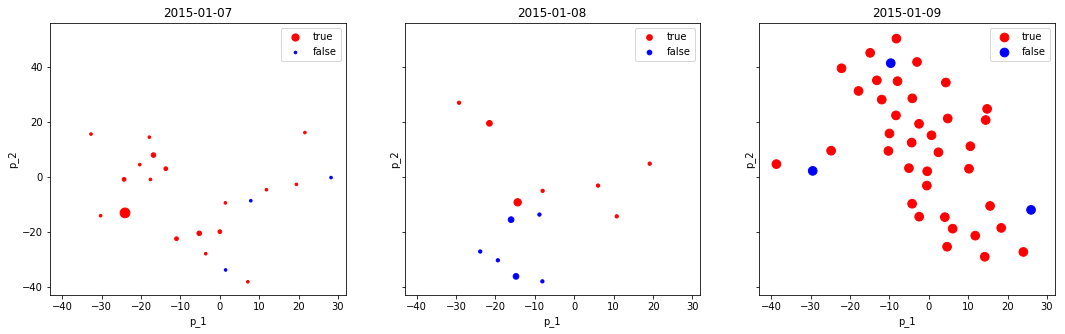

In [165]:
# Visualize sample weights

# Initialize figure
fig, ax = plt.subplots(ncols=len(days), figsize=(18,5), sharex=True, sharey=True)

# Loop over days
for d, day in enumerate(days):
    
    # Take indices of today
    ix_d = (tweets_r['created_date'] == day).values
    
    # Split data
    X_d = Z[ix_d, :]
    Y_d = Y[ix_d]

    ax[d].scatter(X_d[Y_d == 0, 0], X_d[Y_d == 0, 1], s=iw[d][Y_d == 0]*150, color='r', label='true')
    ax[d].scatter(X_d[Y_d == 1, 0], X_d[Y_d == 1, 1], s=iw[d][Y_d == 1]*150, color='b', label='false')
    ax[d].set_title(day)
    ax[d].set_xlabel('p_1')
    ax[d].set_ylabel('p_2')
    ax[d].legend()
    
plt.show()

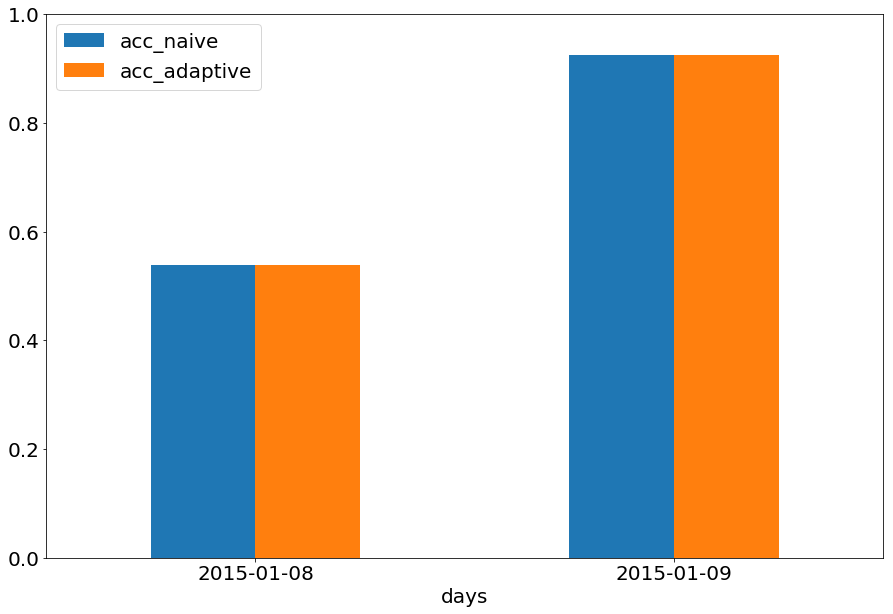

In [166]:
# Visualize performance in bar graph

# Initialize figure
fig, ax = plt.subplots(figsize=(15, 10))

# Use pandas to show bar plots
results.plot(kind='bar', ax=ax, x='days', rot=0, fontsize=fS);

# Set axes properties
ax.set_ylim([0, 1]);
ax.legend(fontsize=fS, loc=2);
ax.set_xlabel('days', fontsize=fS);

The importance-weighted logistic regressor seems to improve over the naive logistic regressor.

## Sequential adaptation

The next step would be to set up a sequentially adaptive classifier. My current adaptive classifier optimizes performance with respect to the single source domain (here, data from the previous day). A sequentially adaptive classifier optimizes performance with respect to a sequence of source domains.